# Graph Embeddings

Bioinformatics reading group, 8 Nov 2019

Yi Liu

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

Outline

- DeepWalk: intro to graph embeddings
- DeepWalk example
- Node2Vec
- DeepGL
- References

## Graph and graph embeddings

$$
G = (V, E, X, Y)    
$$

$$
f(X) \rightarrow Y
$$
- $V$: vertices
- $E$: edges
- $X$: attributes
- $Y$: labels

![](assets/img/graph-example.png)

## Word2Vec (SkipGram)

![](assets/img/skipgram-flow.png)

![](assets/img/skipgram-context-window.png)

## DeepWalk
From sentence embeddings to graph embeddings

![](assets/img/deepwalk-flow.png)

![](assets/img/deepwalk-algo.png)

![](assets/img/skipgram-algo.png)

![](assets/img/graph-example.png)

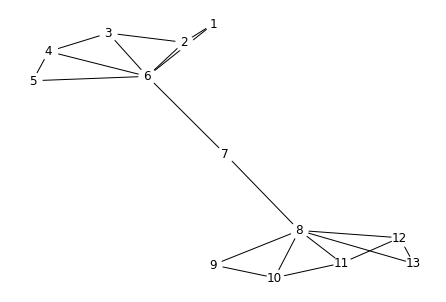

In [2]:
import numpy as np
import networkx as nx

nx_graph = nx.Graph()
nodes = list(np.arange(1, 14))
# fmt: off
edges = [
    (1, 2), (2, 3), (3, 4), (4, 5),
    (1, 6), (2, 6), (3, 6), (4, 6), (5, 6),
    (6, 7),
    (7, 8),
    (9, 8), (10, 8), (11, 8), (12, 8), (13, 8),
    (9, 10), (10, 11), (11, 12), (12, 13),
]
# fmt: on
nx_graph.add_nodes_from(nodes)
nx_graph.add_edges_from(edges)
nx.draw(nx_graph, with_labels=True, node_color="white")

In [3]:
# https://github.com/phanein/deepwalk/blob/master/deepwalk/__main__.py
import random

import deepwalk
from deepwalk import walks as serialized_walks
from deepwalk.skipgram import Skipgram
from gensim.models import Word2Vec
from six import iterkeys

In [4]:
deepwalk_graph = deepwalk.graph.Graph()

for idx, x in enumerate(nx_graph.nodes()):
    for y in iterkeys(nx_graph[x]):
        deepwalk_graph[x].append(y)
        
deepwalk_graph.make_undirected()
deepwalk_graph

Graph(list,
      {1: [2, 6],
       2: [1, 3, 6],
       3: [2, 4, 6],
       4: [3, 5, 6],
       5: [4, 6],
       6: [1, 2, 3, 4, 5, 7],
       7: [6, 8],
       8: [7, 9, 10, 11, 12, 13],
       9: [8, 10],
       10: [8, 9, 11],
       11: [8, 10, 12],
       12: [8, 11, 13],
       13: [8, 12]})

In [5]:
# hyper-params

# num random walks per node: 80
NUM_WALKS = 80
# length of one random walk: 40
WALK_LENGTH = 40
# window size 10
WINDOW_SIZE = 10
# embedding dim 128
EMBEDDING_DIM = 128

In [6]:
walks = deepwalk.graph.build_deepwalk_corpus(
    deepwalk_graph,
    num_paths=NUM_WALKS,
    path_length=WALK_LENGTH,
    alpha=0,
    rand=random.Random(123)
)
print(np.array(walks))
print(np.array(walks).shape)

[['9' '10' '11' ... '12' '13' '8']
 ['6' '5' '6' ... '8' '10' '11']
 ['8' '10' '11' ... '9' '10' '9']
 ...
 ['13' '8' '10' ... '6' '4' '6']
 ['6' '4' '5' ... '7' '8' '12']
 ['8' '12' '13' ... '9' '10' '8']]
(1040, 40)


In [7]:
model = Word2Vec(
    walks,
    size=EMBEDDING_DIM,
    window=WINDOW_SIZE,
    min_count=0,
    sg=1,
    hs=1,
    workers=1,
)

In [8]:
# nodes, or "vocabulary"
model.wv.vocab

{'9': <gensim.models.keyedvectors.Vocab at 0x1a1d7b6810>,
 '10': <gensim.models.keyedvectors.Vocab at 0x1a1d7b6890>,
 '11': <gensim.models.keyedvectors.Vocab at 0x1a1d7b68d0>,
 '8': <gensim.models.keyedvectors.Vocab at 0x1a1d7b6910>,
 '7': <gensim.models.keyedvectors.Vocab at 0x1a1d7b6990>,
 '6': <gensim.models.keyedvectors.Vocab at 0x1a1d7b6a10>,
 '1': <gensim.models.keyedvectors.Vocab at 0x1a1d7b6a50>,
 '3': <gensim.models.keyedvectors.Vocab at 0x1a1d7b6a90>,
 '2': <gensim.models.keyedvectors.Vocab at 0x1a1d7b6950>,
 '4': <gensim.models.keyedvectors.Vocab at 0x1a1d7b69d0>,
 '5': <gensim.models.keyedvectors.Vocab at 0x1a1d7b6ad0>,
 '13': <gensim.models.keyedvectors.Vocab at 0x1a1d7b6b10>,
 '12': <gensim.models.keyedvectors.Vocab at 0x1a1d7b6b50>}

In [9]:
# "word" embeddings
model.wv["1"]

array([-0.00095934, -0.14086728,  0.07352262,  0.13970056, -0.0497438 ,
       -0.2926532 , -0.06589775, -0.10685308,  0.18745854, -0.1012044 ,
       -0.03285081,  0.29395282, -0.01746033, -0.04551164, -0.07437321,
        0.00040195,  0.08093731,  0.04620257,  0.05116988,  0.02569078,
       -0.12490681,  0.02504689,  0.1027611 , -0.08071101, -0.24925862,
        0.12331013, -0.13090487, -0.1167615 ,  0.15161267,  0.00957596,
       -0.12357164,  0.08300231,  0.0844809 , -0.12852252, -0.20644854,
        0.11501899,  0.26970205,  0.07551242, -0.11944196, -0.06687455,
       -0.1480233 , -0.18081237,  0.17705128, -0.07423408, -0.08211829,
        0.26821792,  0.0630434 , -0.23834868, -0.00506505,  0.07663959,
       -0.08388641,  0.1582118 , -0.07193353,  0.01382565,  0.00668014,
        0.01537236, -0.07911585,  0.09093268,  0.04782807, -0.04677264,
       -0.23164956, -0.17346524,  0.12032165, -0.0476453 , -0.13943444,
       -0.1260258 ,  0.13450332,  0.10808325, -0.01826159, -0.35

In [10]:
model.most_similar("1")

[('3', 0.9698188304901123),
 ('6', 0.9323770999908447),
 ('2', 0.9054238796234131),
 ('4', 0.8182910084724426),
 ('5', 0.77535080909729),
 ('7', 0.6318682432174683),
 ('9', 0.05110911279916763),
 ('11', 0.05021246522665024),
 ('10', 0.03185462951660156),
 ('8', 0.02739347517490387)]

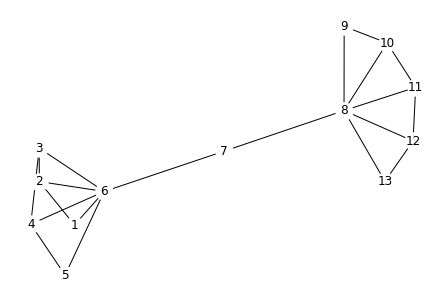

In [11]:
nx.draw(nx_graph, with_labels=True, node_color="white")

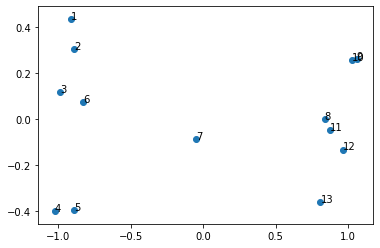

In [12]:
# Visualisation of "word" embeddings using PCA
from sklearn.decomposition import PCA
from matplotlib import pyplot

def plot_pca(model):
    X = model[model.wv.vocab]
    pca = PCA(n_components=2)
    result = pca.fit_transform(X)

    pyplot.scatter(result[:, 0], result[:, 1])
    words = list(model.wv.vocab)
    for i, word in enumerate(words):
        pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))
    pyplot.show()
    
plot_pca(model)

## Node2Vec

Search strategies
- BFS: Breadth-first Sampling
- DFS: Depth-first Sampling

![](assets/img/dfs-bfs-0.jpg)

Node similarities in embedding space

- Homophily: 
  - Similarity in terms of the neighbouring of nodes
- Structural equivalence: 
  - Similarity in terms of structural roles; not emphasized on connectivity

![](assets/img/dfs-bfs-1.jpg)

2nd order random walk:

- Mixture of BFS and DFS
- Search bias $\alpha$:
  - $p$: likelihood of immediately revisiting a node 
  - $q$: larger $q$ biased towards reversion, smaller $q$ biased towards visiting new nodes
- semi-supervised learning: decide p, q from labeled nodes


![](assets/img/node2vec-bias.png)

![](assets/img/node2vec-algo.png)

In [13]:
from node2vec import Node2Vec

In [14]:
node2vec = Node2Vec(
    nx_graph, dimensions=EMBEDDING_DIM, walk_length=WALK_LENGTH, num_walks=NUM_WALKS
)

Generating walks (CPU: 1): 100%|██████████| 80/80 [00:01<00:00, 63.13it/s]


In [15]:
print(
    "walks: \n", np.array(node2vec.walks), 
    "\n\n",
    "shape: ", np.array(node2vec.walks).shape 
)

walks: 
 [['9' '10' '11' ... '3' '4' '5']
 ['6' '3' '4' ... '2' '1' '2']
 ['12' '11' '12' ... '1' '2' '6']
 ...
 ['5' '4' '6' ... '8' '11' '8']
 ['10' '11' '12' ... '3' '6' '3']
 ['11' '8' '13' ... '8' '9' '10']] 

 shape:  (1040, 40)


In [16]:
model = node2vec.fit(window=WINDOW_SIZE, min_count=0)

In [17]:
model.wv.vocab

{'9': <gensim.models.keyedvectors.Vocab at 0x1a1e4f6710>,
 '10': <gensim.models.keyedvectors.Vocab at 0x1a1e4f6750>,
 '11': <gensim.models.keyedvectors.Vocab at 0x1a1e4f6790>,
 '8': <gensim.models.keyedvectors.Vocab at 0x1a1e4f6810>,
 '7': <gensim.models.keyedvectors.Vocab at 0x1a1e4f6890>,
 '6': <gensim.models.keyedvectors.Vocab at 0x1a1e4f6910>,
 '2': <gensim.models.keyedvectors.Vocab at 0x1a1e4f6950>,
 '5': <gensim.models.keyedvectors.Vocab at 0x1a1e4f6990>,
 '4': <gensim.models.keyedvectors.Vocab at 0x1a1e4f6850>,
 '3': <gensim.models.keyedvectors.Vocab at 0x1a1e4f68d0>,
 '1': <gensim.models.keyedvectors.Vocab at 0x1a1e4f69d0>,
 '12': <gensim.models.keyedvectors.Vocab at 0x1a1e4f6a10>,
 '13': <gensim.models.keyedvectors.Vocab at 0x1a1e4f6a50>}

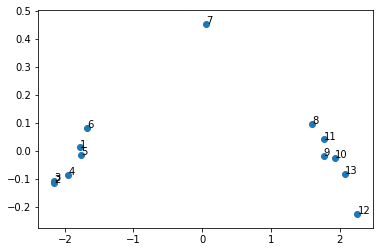

In [18]:
plot_pca(model)

## EpiGraphDB

http://epigraphdb.org/gallery/?name=efo_leukemia&type=2d

![](assets/img/efo_leukemia.png)

In [19]:
import json

with open("assets/epigraphdb_efo_leukemia.json", "r") as f:
    epigraphdb_data = json.load(f)

In [20]:
from pprint import pprint
pprint(epigraphdb_data["nodes"][:3])
pprint(epigraphdb_data["edges"][:3])

[{'id': 44,
  'label': 'Diagnoses - secondary ICD10: Y91.9 Alcohol involvement, not '
           'otherwise specified'},
 {'id': 37,
  'label': 'Diagnoses - secondary ICD9: 59979 Haematuria (not otherwise '
           'specified)'},
 {'id': 31,
  'label': 'Diagnoses - main ICD10: J40 Bronchitis, not specified as acute or '
           'chronic'}]
[{'from': 57, 'to': 69}, {'from': 57, 'to': 71}, {'from': 57, 'to': 70}]


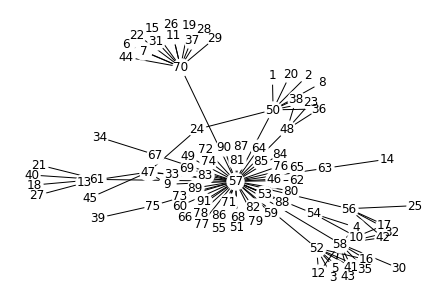

In [21]:
epigraphdb_graph = nx.Graph()
epigraphdb_graph.add_nodes_from([item["id"] for item in epigraphdb_data["nodes"]])
epigraphdb_graph.add_edges_from([(item["from"], item["to"]) for item in epigraphdb_data["edges"]])
nx.draw(epigraphdb_graph, with_labels=True, node_color="white")

In [22]:
epigraphdb_node2vec = Node2Vec(
    epigraphdb_graph, dimensions=EMBEDDING_DIM, walk_length=WALK_LENGTH, num_walks=NUM_WALKS
)

Generating walks (CPU: 1): 100%|██████████| 80/80 [00:09<00:00,  8.67it/s]


In [23]:
epigraphdb_model = epigraphdb_node2vec.fit(window=WINDOW_SIZE, min_count=0)

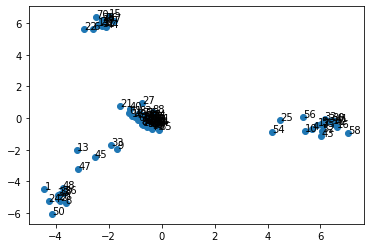

In [24]:
plot_pca(epigraphdb_model)

In [25]:
epigraphdb_model.most_similar("24")

[('45', 0.7994406819343567),
 ('2', 0.7983152866363525),
 ('20', 0.7964375019073486),
 ('47', 0.7630603909492493),
 ('8', 0.7575975656509399),
 ('13', 0.7530874013900757),
 ('50', 0.7519896626472473),
 ('1', 0.746828019618988),
 ('33', 0.7092547416687012),
 ('9', 0.7086656093597412)]

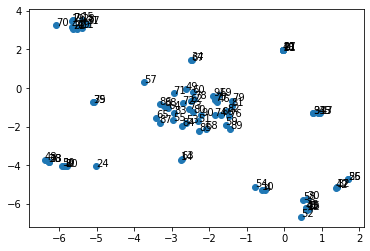

In [26]:
from sklearn.manifold import TSNE

def plot_tsne(model):
    X = model[model.wv.vocab]
    result = TSNE(n_components=2).fit_transform(X)
    
    pyplot.scatter(result[:, 0], result[:, 1])
    words = list(model.wv.vocab)
    for i, word in enumerate(words):
        pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))
    pyplot.show()
    
plot_tsne(epigraphdb_model)

## References

- DeepWalk: https://arxiv.org/abs/1403.6652
- Node2Vec: https://cs.stanford.edu/~jure/pubs/node2vec-kdd16.pdf
- http://media.cs.tsinghua.edu.cn/~multimedia/cuipeng/papers/Network%20Representation-Tutorial.pdf
- https://medium.com/@_init_/an-illustrated-explanation-of-using-skipgram-to-encode-the-structure-of-a-graph-deepwalk-6220e304d71b
- https://towardsdatascience.com/graph-embeddings-the-summary-cc6075aba007
- https://towardsdatascience.com/node2vec-embeddings-for-graph-data-32a866340fef
- https://neo4j.com/online-summit/session/graph-embeddings-machine-learning-ml